In [1]:
print('Connect to google drive')
from google.colab import drive
drive.mount('/gdrive')

Connect to google drive
Mounted at /gdrive


In [2]:
print('Import necessary libraries')

import numpy as np
import pandas as pd
import scipy.stats as stats
from pathlib import Path
import glob
import pickle

import warnings
warnings.filterwarnings("ignore")

import random
import os
os.environ["CUDA_VISIBLE_DEVICES"]="0"
import gc
import tqdm

from sklearn.model_selection import StratifiedKFold, GroupKFold
from sklearn.preprocessing import StandardScaler, LabelEncoder

import joblib
import lightgbm as lgb


Import necessary libraries


In [3]:
base_path='/gdrive/My Drive/Colab Notebooks/'
weights_path='/gdrive/My Drive/Colab Notebooks/weights/'

In [4]:
def euclidean_distance(x_true,y_true, x_pred, y_pred):
    return np.mean(((x_true-x_pred)**2+(y_true-y_pred)**2)**0.5)    

In [5]:
version='forPdata423_numBSSIDS'


In [6]:
data=pd.read_csv('/gdrive/My Drive/Colab Notebooks/data423.csv.zip') #
data.shape

(14373, 316)

In [13]:
rssidsnums=[int(x[4:]) for x in data.columns if 'rsid' in x]
print(len(rssidsnums))

312


In [7]:
data.head()

,rsid1,rsid2,rsid3,rsid4,rsid5,rsid6,rsid7,rsid8,rsid9,rsid10,rsid11,rsid12,rsid13,rsid14,rsid15,rsid16,rsid17,rsid18,rsid19,rsid20,rsid21,rsid22,rsid23,rsid24,rsid25,rsid26,rsid27,rsid28,rsid29,rsid30,rsid31,rsid32,rsid33,rsid34,rsid35,rsid36,rsid37,rsid38,rsid39,rsid40,...,rsid277,rsid278,rsid279,rsid280,rsid281,rsid282,rsid283,rsid284,rsid285,rsid286,rsid287,rsid288,rsid289,rsid290,rsid291,rsid292,rsid293,rsid294,rsid295,rsid296,rsid297,rsid298,rsid299,rsid300,rsid301,rsid302,rsid303,rsid304,rsid305,rsid306,rsid307,rsid308,rsid309,rsid310,rsid311,rsid312,x,y,timestamp,path
0,-93,-999,-81,-999,-999,-999,-999,-999,-999,-999,-999,-85,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-48,-48,-49,-44,-43,-43,-999,-999,-999,-999,-999,-999,...,-81,-80,-999,-999,-999,-87,-999,-999,-78,-79,-78,-79,-79,-78,-999,-999,-999,-999,-999,-999,-999,-81,-82,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,43.26,25.89,1633934464983,record_2021_10_11_07_41_02
1,-93,-999,-81,-999,-999,-999,-999,-999,-999,-999,-999,-85,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-48,-48,-49,-44,-43,-43,-999,-999,-999,-999,-999,-999,...,-81,-80,-999,-999,-999,-87,-999,-999,-78,-79,-78,-79,-79,-78,-999,-999,-999,-999,-999,-999,-999,-81,-82,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,43.26,25.89,1633934467125,record_2021_10_11_07_41_02
2,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-84,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-56,-999,-999,-39,-43,-42,-999,-999,-999,-999,-999,-999,...,-82,-82,-84,-85,-81,-87,-999,-999,-999,-999,-85,-999,-88,-999,-999,-999,-999,-999,-999,-999,-999,-85,-86,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,43.26,25.89,1633934469251,record_2021_10_11_07_41_02
3,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-84,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-56,-999,-999,-39,-43,-42,-999,-999,-999,-999,-999,-999,...,-82,-82,-84,-85,-81,-87,-999,-999,-999,-999,-85,-999,-88,-999,-999,-999,-999,-999,-999,-999,-999,-85,-86,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,43.26,25.89,1633934471370,record_2021_10_11_07_41_02
4,-78,-999,-999,-95,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-50,-51,-51,-43,-49,-47,-999,-999,-999,-999,-999,-999,...,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-87,-87,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,40.85,25.74,1633934473508,record_2021_10_11_07_41_02


In [8]:
TRAIN_FEATS=[x for x in data.columns if x not in ['x', 'y', 'path', 'timestamp']]
len(TRAIN_FEATS)

312

In [9]:
unpaths=data.path.unique()

In [10]:
print('we have ',len(unpaths),' unique paths')

we have  423  unique paths


### CV TRAIN

In [11]:
hyper_params = {
    'task': 'train',
    'boosting_type': 'gbdt',
    'objective': 'regression',
    'metric': ['l1','l2'],
    'learning_rate': 0.005,
    'feature_fraction': 0.2,
    'bagging_fraction': 0.8,
    'bagging_freq': 10,
    'verbose': 0,
    "max_depth": 11,
    "num_leaves": 256,  
    "max_bin": 256,
    "num_iterations": 15000
}
# hyper_params = {
#     'task': 'train',
#     'boosting_type': 'gbdt',
#     'objective': 'regression',
#     'metric': ['l1','l2'],
#     'learning_rate': 0.005,
#     'feature_fraction': 0.2,
#     'bagging_fraction': 0.8,
#     'bagging_freq': 10,
#     'verbose': 0,
#     "max_depth": 14,
#     "num_leaves": 256,  
#     "max_bin": 256,
#     "num_iterations": 15000
# }


In [15]:
# CROSS VALIDATION

name='lgbm'+version


scores=[]
for rs in range(100):
    np.random.seed(2022+rs)
    selected_rsidnums=np.sort(np.random.choice(np.arange(min(rssidsnums),max(rssidsnums)), size=234,replace=False))
    selected_rsids=['rsid'+str(x) for x in selected_rsidnums]
    TRAIN_FEATS=selected_rsids[:]
    # print(len(selected_rsids))

    score_df = pd.DataFrame()
    oof = list()
    predictions = list()

    oof_x, oof_y = np.zeros(data.shape[0]), np.zeros(data.shape[0])
    preds_x, preds_y = 0, 0

    scores_per_fold=[]

    all_preds=[]
    all_targets=[]

    np.random.seed(42)
    sh=np.random.permutation(unpaths)


    k=5
    val_size=int(len(sh)/k)
    for f in range(k):
        # print('fold:', f)

        if f<(k-1):
            val_paths=sh[val_size*f:val_size*(f+1)]
        else:
            val_paths=sh[val_size*f:]

        train_paths=[x for x in unpaths if x not in val_paths]
        
        val_paths=np.array(val_paths)
        train_paths=np.array(train_paths)
        
        X_train = data.loc[data.path.isin(train_paths), TRAIN_FEATS ].reset_index(drop=True)

        y_trainXY =  data.loc[data.path.isin(train_paths), ['x', 'y'] ].reset_index(drop=True).values

        X_val = data.loc[data.path.isin(val_paths), TRAIN_FEATS ].reset_index(drop=True)
        y_valXY = data.loc[data.path.isin(val_paths), ['x', 'y'] ].reset_index(drop=True).values

        val_predsXY=[]
        for i in range(2):
            y_train = y_trainXY[:,i]
            y_val = y_valXY[:,i]

            gbm = lgb.LGBMRegressor(**hyper_params)
            model = gbm.fit(X_train, y_train,
                eval_set=[(X_train, y_train), (X_val, y_val)],
                eval_metric='l1',
                verbose=1000,
                # verbose=100,
                early_stopping_rounds=200)
            
            joblib.dump(model, weights_path+'fold_'+str(f)+['x','y'][i]+'_v2')
            
            val_predsXY.append(gbm.predict(X_val, num_iteration=gbm.best_iteration_) )
        val_predsXY=np.stack(val_predsXY).T
        
        # print(euclidean_distance(val_predsXY[:,0], val_predsXY[:,1], y_valXY[:,0], y_valXY[:,1]))

        all_preds.append(val_predsXY)
        all_targets.append(y_valXY)
            

    all_predsV=np.vstack(all_preds)
    all_targetsV=np.vstack(all_targets)    
    print(rs,'mean validation error, 5-fold', euclidean_distance(all_targetsV[:,0], all_targetsV[:,1], all_predsV[:,0], all_predsV[:,1]))
    scores.append(euclidean_distance(all_targetsV[:,0], all_targetsV[:,1], all_predsV[:,0], all_predsV[:,1]))
    print(np.mean(scores))
    print('---------------------')

Training until validation scores don't improve for 200 rounds.
[1000]	training's l2: 1.43107	training's l1: 0.866326	valid_1's l2: 4.50309	valid_1's l1: 1.45143
[2000]	training's l2: 1.13347	training's l1: 0.768194	valid_1's l2: 4.44262	valid_1's l1: 1.43314
[3000]	training's l2: 0.986995	training's l1: 0.714373	valid_1's l2: 4.42668	valid_1's l1: 1.42674
Early stopping, best iteration is:
[2945]	training's l2: 0.993162	training's l1: 0.71665	valid_1's l2: 4.42487	valid_1's l1: 1.42664
Training until validation scores don't improve for 200 rounds.
[1000]	training's l2: 0.852396	training's l1: 0.600031	valid_1's l2: 2.74268	valid_1's l1: 1.08217
[2000]	training's l2: 0.659311	training's l1: 0.51322	valid_1's l2: 2.69011	valid_1's l1: 1.06398
Early stopping, best iteration is:
[2023]	training's l2: 0.656806	training's l1: 0.5119	valid_1's l2: 2.68992	valid_1's l1: 1.06376
Training until validation scores don't improve for 200 rounds.
[1000]	training's l2: 1.46666	training's l1: 0.866065	

KeyboardInterrupt: ignored

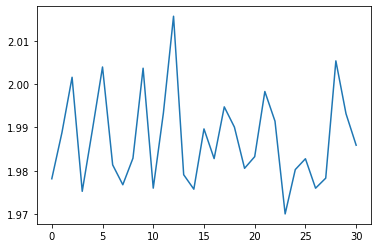

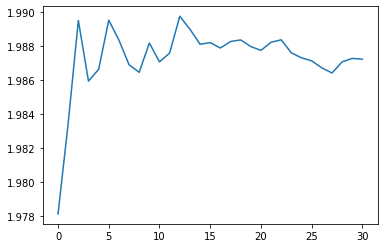

1.9872329335552117
0.010711067614484685


In [17]:
import matplotlib.pyplot as plt
plt.plot(scores)
plt.show()

plt.plot(np.cumsum(scores)/np.arange(1,len(scores)+1))
plt.show()

print(np.mean(scores))
print(np.std(scores))

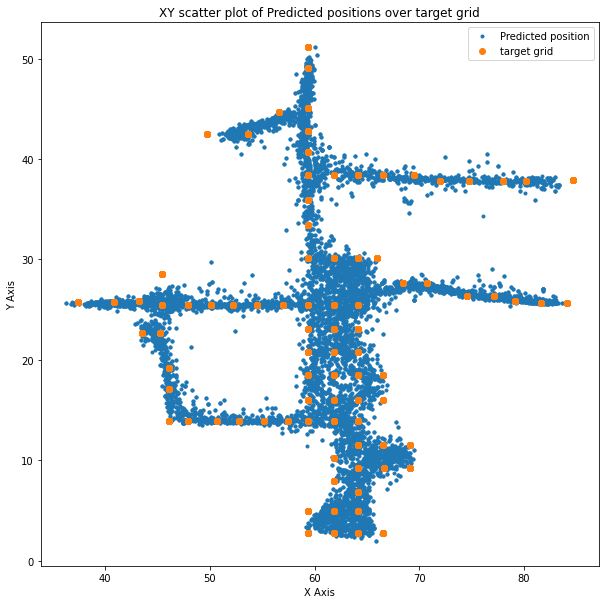

mean validation error, 5-fold 1.9858936195073764


In [20]:
plt.figure(figsize=(10,10))
plt.title('XY scatter plot of Predicted positions over target grid')
plt.plot(all_predsV[:,0],all_predsV[:,1],'.', label='Predicted position')
plt.plot(all_targetsV[:,0],all_targetsV[:,1],'o', label='target grid')
plt.legend()
plt.xlabel('X Axis')
plt.ylabel('Y Axis')
plt.show()
print('mean validation error, 5-fold', euclidean_distance(all_targetsV[:,0], all_targetsV[:,1], all_predsV[:,0], all_predsV[:,1]))

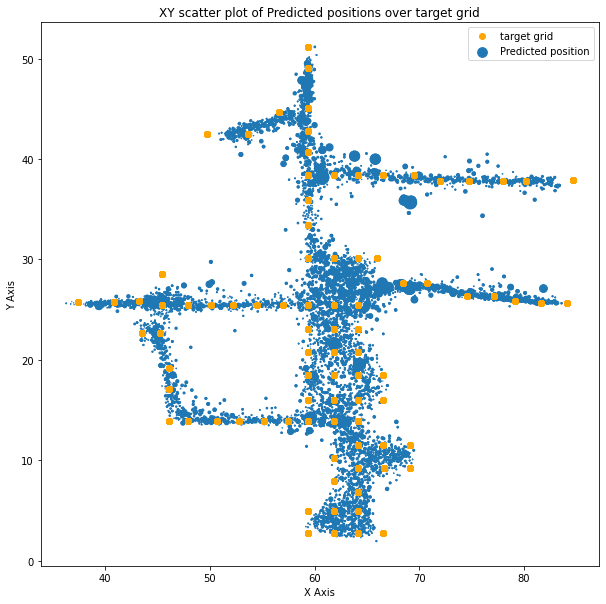

mean validation error, 5-fold 1.9858936195073764


In [22]:
scoreperrow=[]
for row in range(len(all_targetsV)):
    scoreperrow.append(euclidean_distance(all_targetsV[row,0], all_targetsV[row,1], all_predsV[row,0], all_predsV[row,1]))
    
plt.figure(figsize=(10,10))
plt.title('XY scatter plot of Predicted positions over target grid')
plt.plot(all_targetsV[:,0],all_targetsV[:,1],'o', color="orange", label='target grid')
plt.scatter(all_predsV[:,0],all_predsV[:,1],s=0.5*np.array(scoreperrow)**2, label='Predicted position')
plt.legend()
plt.xlabel('X Axis')
plt.ylabel('Y Axis')
plt.show()
print('mean validation error, 5-fold', euclidean_distance(all_targetsV[:,0], all_targetsV[:,1], all_predsV[:,0], all_predsV[:,1]))

In [24]:
# CROSS VALIDATION

name='lgbm'+version


scores=[]
for rs in range(100):
    np.random.seed(2022+rs)
    selected_rsidnums=np.sort(np.random.choice(np.arange(min(rssidsnums),max(rssidsnums)), size=156,replace=False))
    selected_rsids=['rsid'+str(x) for x in selected_rsidnums]
    TRAIN_FEATS=selected_rsids[:]
    # print(len(selected_rsids))

    score_df = pd.DataFrame()
    oof = list()
    predictions = list()

    oof_x, oof_y = np.zeros(data.shape[0]), np.zeros(data.shape[0])
    preds_x, preds_y = 0, 0

    scores_per_fold=[]

    all_preds=[]
    all_targets=[]

    np.random.seed(42)
    sh=np.random.permutation(unpaths)


    k=5
    val_size=int(len(sh)/k)
    for f in range(k):
        # print('fold:', f)

        if f<(k-1):
            val_paths=sh[val_size*f:val_size*(f+1)]
        else:
            val_paths=sh[val_size*f:]

        train_paths=[x for x in unpaths if x not in val_paths]
        
        val_paths=np.array(val_paths)
        train_paths=np.array(train_paths)
        
        X_train = data.loc[data.path.isin(train_paths), TRAIN_FEATS ].reset_index(drop=True)

        y_trainXY =  data.loc[data.path.isin(train_paths), ['x', 'y'] ].reset_index(drop=True).values

        X_val = data.loc[data.path.isin(val_paths), TRAIN_FEATS ].reset_index(drop=True)
        y_valXY = data.loc[data.path.isin(val_paths), ['x', 'y'] ].reset_index(drop=True).values

        val_predsXY=[]
        for i in range(2):
            y_train = y_trainXY[:,i]
            y_val = y_valXY[:,i]

            gbm = lgb.LGBMRegressor(**hyper_params)
            model = gbm.fit(X_train, y_train,
                eval_set=[(X_train, y_train), (X_val, y_val)],
                eval_metric='l1',
                verbose=1000,
                # verbose=100,
                early_stopping_rounds=200)
            
            joblib.dump(model, weights_path+'fold_'+str(f)+['x','y'][i]+'_v2')
            
            val_predsXY.append(gbm.predict(X_val, num_iteration=gbm.best_iteration_) )
        val_predsXY=np.stack(val_predsXY).T
        
        # print(euclidean_distance(val_predsXY[:,0], val_predsXY[:,1], y_valXY[:,0], y_valXY[:,1]))

        all_preds.append(val_predsXY)
        all_targets.append(y_valXY)
            

    all_predsV=np.vstack(all_preds)
    all_targetsV=np.vstack(all_targets)    
    print(rs,'mean validation error, 5-fold', euclidean_distance(all_targetsV[:,0], all_targetsV[:,1], all_predsV[:,0], all_predsV[:,1]))
    scores.append(euclidean_distance(all_targetsV[:,0], all_targetsV[:,1], all_predsV[:,0], all_predsV[:,1]))
    print(np.mean(scores))
    print('---------------------')

Training until validation scores don't improve for 200 rounds.
[1000]	training's l2: 1.64977	training's l1: 0.931598	valid_1's l2: 4.65056	valid_1's l1: 1.49182
[2000]	training's l2: 1.27901	training's l1: 0.819489	valid_1's l2: 4.55808	valid_1's l1: 1.46963
[3000]	training's l2: 1.10167	training's l1: 0.758009	valid_1's l2: 4.53089	valid_1's l1: 1.4629
[4000]	training's l2: 0.971354	training's l1: 0.708433	valid_1's l2: 4.52073	valid_1's l1: 1.4604
Early stopping, best iteration is:
[4056]	training's l2: 0.966632	training's l1: 0.706617	valid_1's l2: 4.51997	valid_1's l1: 1.46034
Training until validation scores don't improve for 200 rounds.
[1000]	training's l2: 0.991656	training's l1: 0.658066	valid_1's l2: 2.95477	valid_1's l1: 1.14579
[2000]	training's l2: 0.7462	training's l1: 0.559213	valid_1's l2: 2.89047	valid_1's l1: 1.12624
Early stopping, best iteration is:
[2289]	training's l2: 0.710017	training's l1: 0.543421	valid_1's l2: 2.88778	valid_1's l1: 1.12561
Training until vali

KeyboardInterrupt: ignored

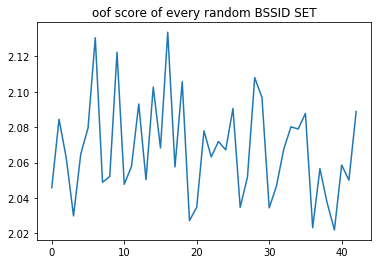

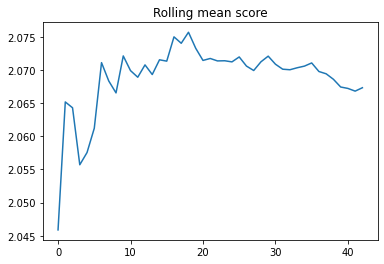

43
2.067338179891052
0.028056745598366854


In [29]:
import matplotlib.pyplot as plt
plt.plot(scores)
plt.title('oof score of every random BSSID SET')
plt.show()

plt.plot(np.cumsum(scores)/np.arange(1,len(scores)+1))
plt.title('Rolling mean score')
plt.show()

print(len(scores))
print(np.mean(scores))
print(np.std(scores))

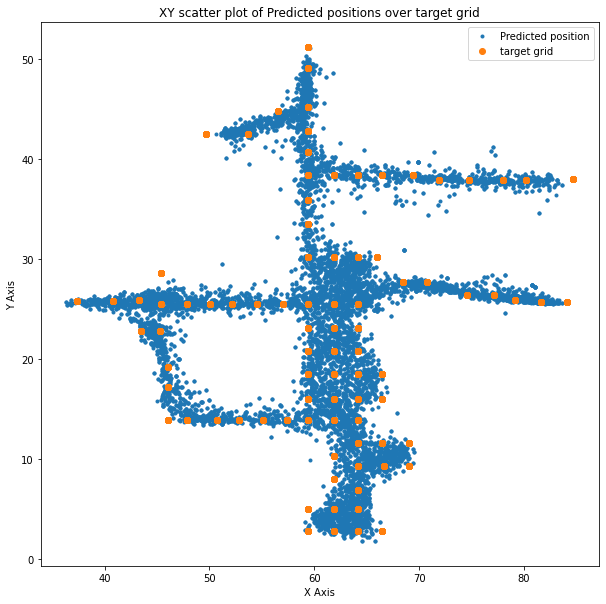

mean validation error, 5-fold 2.0888760159129167


In [26]:
plt.figure(figsize=(10,10))
plt.title('XY scatter plot of Predicted positions over target grid')
plt.plot(all_predsV[:,0],all_predsV[:,1],'.', label='Predicted position')
plt.plot(all_targetsV[:,0],all_targetsV[:,1],'o', label='target grid')
plt.legend()
plt.xlabel('X Axis')
plt.ylabel('Y Axis')
plt.show()
print('mean validation error, 5-fold', euclidean_distance(all_targetsV[:,0], all_targetsV[:,1], all_predsV[:,0], all_predsV[:,1]))

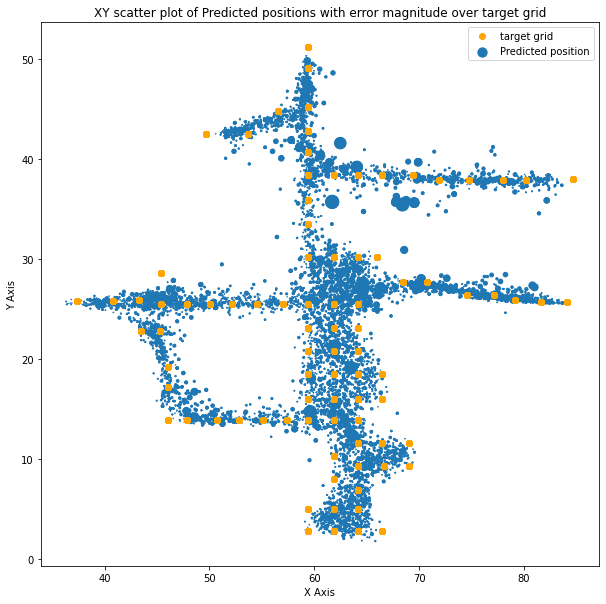

mean validation error, 5-fold 2.0888760159129167


In [30]:
scoreperrow=[]
for row in range(len(all_targetsV)):
    scoreperrow.append(euclidean_distance(all_targetsV[row,0], all_targetsV[row,1], all_predsV[row,0], all_predsV[row,1]))
    
plt.figure(figsize=(10,10))
plt.title('XY scatter plot of Predicted positions with error magnitude over target grid')
plt.plot(all_targetsV[:,0],all_targetsV[:,1],'o', color="orange", label='target grid')
plt.scatter(all_predsV[:,0],all_predsV[:,1],s=0.5*np.array(scoreperrow)**2, label='Predicted position')
plt.legend()
plt.xlabel('X Axis')
plt.ylabel('Y Axis')
plt.show()
print('mean validation error, 5-fold', euclidean_distance(all_targetsV[:,0], all_targetsV[:,1], all_predsV[:,0], all_predsV[:,1]))

In [31]:
# CROSS VALIDATION

name='lgbm'+version


scores=[]
for rs in range(100):
    np.random.seed(2022+rs)
    selected_rsidnums=np.sort(np.random.choice(np.arange(min(rssidsnums),max(rssidsnums)), size=78,replace=False))
    selected_rsids=['rsid'+str(x) for x in selected_rsidnums]
    TRAIN_FEATS=selected_rsids[:]
    # print(len(selected_rsids))

    score_df = pd.DataFrame()
    oof = list()
    predictions = list()

    oof_x, oof_y = np.zeros(data.shape[0]), np.zeros(data.shape[0])
    preds_x, preds_y = 0, 0

    scores_per_fold=[]

    all_preds=[]
    all_targets=[]

    np.random.seed(42)
    sh=np.random.permutation(unpaths)


    k=5
    val_size=int(len(sh)/k)
    for f in range(k):
        # print('fold:', f)

        if f<(k-1):
            val_paths=sh[val_size*f:val_size*(f+1)]
        else:
            val_paths=sh[val_size*f:]

        train_paths=[x for x in unpaths if x not in val_paths]
        
        val_paths=np.array(val_paths)
        train_paths=np.array(train_paths)
        
        X_train = data.loc[data.path.isin(train_paths), TRAIN_FEATS ].reset_index(drop=True)

        y_trainXY =  data.loc[data.path.isin(train_paths), ['x', 'y'] ].reset_index(drop=True).values

        X_val = data.loc[data.path.isin(val_paths), TRAIN_FEATS ].reset_index(drop=True)
        y_valXY = data.loc[data.path.isin(val_paths), ['x', 'y'] ].reset_index(drop=True).values

        val_predsXY=[]
        for i in range(2):
            y_train = y_trainXY[:,i]
            y_val = y_valXY[:,i]

            gbm = lgb.LGBMRegressor(**hyper_params)
            model = gbm.fit(X_train, y_train,
                eval_set=[(X_train, y_train), (X_val, y_val)],
                eval_metric='l1',
                verbose=1000,
                # verbose=100,
                early_stopping_rounds=200)
            
            joblib.dump(model, weights_path+'fold_'+str(f)+['x','y'][i]+'_v2')
            
            val_predsXY.append(gbm.predict(X_val, num_iteration=gbm.best_iteration_) )
        val_predsXY=np.stack(val_predsXY).T
        
        # print(euclidean_distance(val_predsXY[:,0], val_predsXY[:,1], y_valXY[:,0], y_valXY[:,1]))

        all_preds.append(val_predsXY)
        all_targets.append(y_valXY)
            

    all_predsV=np.vstack(all_preds)
    all_targetsV=np.vstack(all_targets)    
    print(rs,'mean validation error, 5-fold', euclidean_distance(all_targetsV[:,0], all_targetsV[:,1], all_predsV[:,0], all_predsV[:,1]))
    scores.append(euclidean_distance(all_targetsV[:,0], all_targetsV[:,1], all_predsV[:,0], all_predsV[:,1]))
    print(np.mean(scores))
    print('---------------------')

Training until validation scores don't improve for 200 rounds.
[1000]	training's l2: 3.29355	training's l1: 1.30016	valid_1's l2: 6.88892	valid_1's l1: 1.83897
[2000]	training's l2: 2.32536	training's l1: 1.09127	valid_1's l2: 6.47001	valid_1's l1: 1.77602
[3000]	training's l2: 1.91343	training's l1: 0.990188	valid_1's l2: 6.36361	valid_1's l1: 1.76224
[4000]	training's l2: 1.65658	training's l1: 0.919224	valid_1's l2: 6.32264	valid_1's l1: 1.75685
[5000]	training's l2: 1.48369	training's l1: 0.866648	valid_1's l2: 6.30722	valid_1's l1: 1.75511
Early stopping, best iteration is:
[5361]	training's l2: 1.43319	training's l1: 0.850272	valid_1's l2: 6.30324	valid_1's l1: 1.75418
Training until validation scores don't improve for 200 rounds.
[1000]	training's l2: 1.77633	training's l1: 0.924551	valid_1's l2: 3.86646	valid_1's l1: 1.37795
[2000]	training's l2: 1.17868	training's l1: 0.742531	valid_1's l2: 3.76685	valid_1's l1: 1.34432
Early stopping, best iteration is:
[1934]	training's l2: 

KeyboardInterrupt: ignored

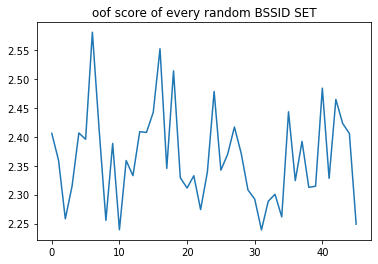

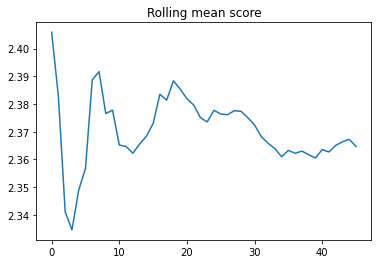

46
2.3646625619221737
0.0802763490993854


In [32]:
import matplotlib.pyplot as plt
plt.plot(scores)
plt.title('oof score of every random BSSID SET')
plt.show()

plt.plot(np.cumsum(scores)/np.arange(1,len(scores)+1))
plt.title('Rolling mean score')
plt.show()

print(len(scores))
print(np.mean(scores))
print(np.std(scores))

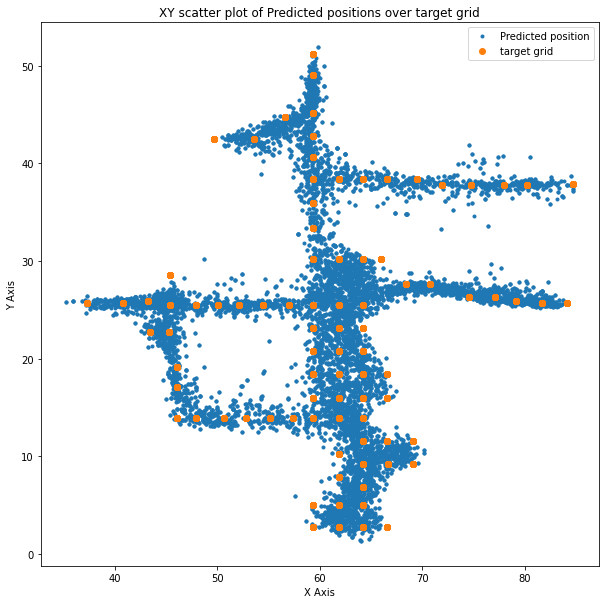

mean validation error, 5-fold 2.248973229222334


In [33]:
plt.figure(figsize=(10,10))
plt.title('XY scatter plot of Predicted positions over target grid')
plt.plot(all_predsV[:,0],all_predsV[:,1],'.', label='Predicted position')
plt.plot(all_targetsV[:,0],all_targetsV[:,1],'o', label='target grid')
plt.legend()
plt.xlabel('X Axis')
plt.ylabel('Y Axis')
plt.show()
print('mean validation error, 5-fold', euclidean_distance(all_targetsV[:,0], all_targetsV[:,1], all_predsV[:,0], all_predsV[:,1]))

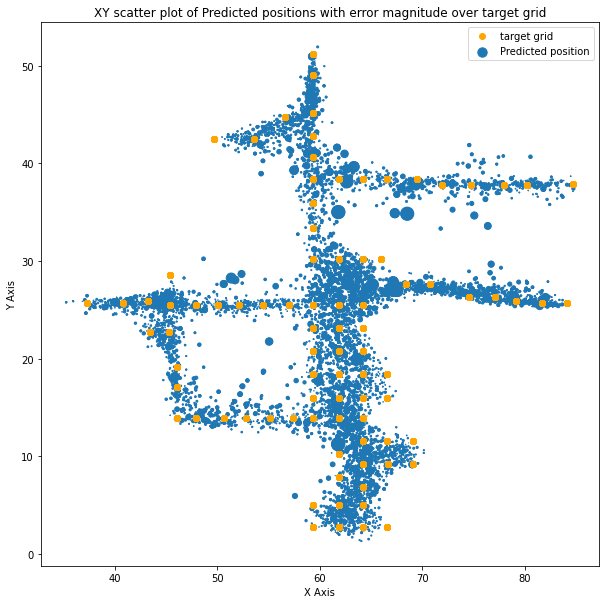

mean validation error, 5-fold 2.248973229222334


In [34]:
scoreperrow=[]
for row in range(len(all_targetsV)):
    scoreperrow.append(euclidean_distance(all_targetsV[row,0], all_targetsV[row,1], all_predsV[row,0], all_predsV[row,1]))
    
plt.figure(figsize=(10,10))
plt.title('XY scatter plot of Predicted positions with error magnitude over target grid')
plt.plot(all_targetsV[:,0],all_targetsV[:,1],'o', color="orange", label='target grid')
plt.scatter(all_predsV[:,0],all_predsV[:,1],s=0.5*np.array(scoreperrow)**2, label='Predicted position')
plt.legend()
plt.xlabel('X Axis')
plt.ylabel('Y Axis')
plt.show()
print('mean validation error, 5-fold', euclidean_distance(all_targetsV[:,0], all_targetsV[:,1], all_predsV[:,0], all_predsV[:,1]))

In [ ]:
# pd.DataFrame(all_predsV,columns=['x', 'y']).to_csv('/gdrive/My Drive/Colab Notebooks/'+name+'_oof2.csv.gz', index=False, compression='gzip')
# pd.DataFrame(all_targetsV,columns=['x', 'y']).to_csv('/gdrive/My Drive/Colab Notebooks/all_targetsV2.csv.gz', index=False, compression='gzip')

In [ ]:
# '/gdrive/My Drive/Colab Notebooks/'+name+'_oof.csv.gz'

In [23]:
version

'forPdata423_numBSSIDS'

## Full train

In [ ]:
# hyper_params["num_iterations"]= 2500

In [ ]:


# name=version+'lgbm'

# train_paths=unpaths[:]

# train_paths=np.array(train_paths)

# X_train = data.loc[data.path.isin(train_paths), TRAIN_FEATS ].reset_index(drop=True)

# y_trainXY =  data.loc[data.path.isin(train_paths), ['x', 'y'] ].reset_index(drop=True).values

# train_predsXY=[]
# all_train_targets=[]
# xy=['x', 'y']
# for i in range(2):
#     y_train = y_trainXY[:,i]

#     gbm = lgb.LGBMRegressor(**hyper_params)


#     model = gbm.fit(X_train, y_train,
#         eval_set=[(X_train, y_train)],
#         eval_metric='l1',
#         verbose=100
#         )
    
#     # joblib.dump(model, weights_path+'FullTrain_'+['x','y'][i])
#     joblib.dump(model,'/gdrive/My Drive/Colab Notebooks/weights/'+name+'_model'+xy[i])

#     train_predsXY.append(gbm.predict(X_train, num_iteration=gbm.best_iteration_) )

# train_predsXY=np.stack(train_predsXY).T

# print('train error',euclidean_distance(train_predsXY[:,0], train_predsXY[:,1], y_trainXY[:,0], y_trainXY[:,1]))


In [ ]:
# print('Save LightGBM model fully trained')
# joblib.dump(model,'/gdrive/My Drive/Colab Notebooks/weights/'+name+'_model')